# Cloning training data 

In [ ]:
!git clone https://github.com/mmi366127/iGem.git

Cloning into 'iGem'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 132 (delta 17), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (132/132), 854.55 KiB | 5.31 MiB/s, done.
Resolving deltas: 100% (17/17), done.


# Reading Data set

In [ ]:
import pandas, os, re

def valid_amino_acid(amino_acid) :
    if len(amino_acid) != 1 : return False
    return amino_acid[0].isalpha()


def valid_CleavageSite(Site) :
    for amino_acid in Site :
        if not valid_amino_acid(amino_acid) :
            return False
    return True

Sites, Names_Site = [], []

for file in os.listdir('/content/iGem/CleavageSite') :

    df = pandas.read_csv(os.path.join('/content/iGem/CleavageSite', file))
    
    rows = [row for row in df.iloc[:, 1:9].values if valid_CleavageSite(row)]
    name = [file[:7] for i in range(len(rows))]

    Sites = Sites + rows
    Names_Site = Names_Site + name

print('Total Sites: %d' % (len(Sites)))

Total Sites: 743


In [ ]:
import numpy as np

AA_index = pandas.read_csv('/content/iGem/AAidx.csv')
AA_index = AA_index.dropna()

AA_index.head()
            
def transform(Site) :
    ret = []
    for amino_acid in Site :
        if amino_acid not in AA_index.columns :
            print('Unknown Amino Acid')
        ret = np.concatenate((ret, AA_index[amino_acid].iloc[:].values), axis = 0)
    
    return ret

AA_Sites = np.array([transform(row) for row in Sites])


In [ ]:

Sequence, Names_Seq = [], []
st = set()

AS_sz = 4

def valid_AS(as_list, pep):
    ret_list = []
    for AS in as_list:
        AS = AS.strip()
        if len(ret_list) >= AS_sz:
            break
        if AS == 'missing' or len(AS) <= 1:
            continue
        if AS[0] in 'HDS':
            ret_list.append(AS)

    for AS in as_list:
        AS = AS.strip()
        if len(ret_list) >= AS_sz:
            break
        if AS == 'missing' or len(AS) <= 1:
            continue
        if AS[0] not in 'HDS':
            ret_list.append(AS)

    if len(ret_list) < 1:
        return -1
    for AS in ret_list:
        cur = int(AS.strip()[1:])
        if cur < pep[0] or cur > pep[1]:
            return -1
    return ret_list

def valid_Protease(Protease_row, f) :
    pep_unit = str(Protease_row[0])
    active_site = str(Protease_row[1])
    Protease = str(Protease_row[2])
    
    pep_pair = pep_unit.split('-')
    pep_list = (int(pep_pair[0]), int(pep_pair[1]))
    if pep_list[0] > pep_list[1] or pep_list[1] > len(Protease) or pep_list[0] < 1:
        return False, False, False

    as_list = active_site.split(',')
    as_list = valid_AS(as_list, pep_list)
    if as_list == -1: return False, False, False

    if len(Protease) < 100: return False, False, False
    if Protease in st : return False, False, False
    st.add(Protease)
    return Protease, as_list, pep_list


for file in os.listdir('/content/iGem/Protease') :

    df = pandas.read_csv(os.path.join('/content/iGem/Protease', file))
    
    rows = []
    for row in df.iloc[:, 3:6].values:
        a, b, c = valid_Protease(row, file)
        if a == False:
            continue
        rows.append([a, b, c])
    name = [file[:7] for i in range(len(rows))]
    Sequence = Sequence + rows
    Names_Seq = Names_Seq + name

print('Total Preteasae Sequences: %d' % (len(Sequence)))


Total Preteasae Sequences: 1504


In [ ]:
Set_Sites = set(np.unique(Names_Site))
Set_Seq = set(np.unique(Names_Seq))

# Data Preprocess

In [ ]:

dic = dict()

for Protease in Sequence :
    for AS in Protease[1] :
        pos = int(AS[1:]) - 1
        for j in range(Protease[2][0] - 1, Protease[2][1]) :
            if j == pos : continue
            key_str = Protease[0][pos] + Protease[0][j]
            key_pos = j - pos
            if (key_str, key_pos) not in dic :
                dic.update({(key_str, key_pos): 1})
            else :
                dic[(key_str, key_pos)] += 1

print(dic)

In [ ]:

threshold = 60
features = set()

for key in dic :
    if dic[key] > threshold :
        features.add(key)

print(features)
print(len(features))

In [ ]:
def gen(features, sequence) :
    ret = []
    for item in features :
        cnt = 0
        for AS in sequence[1] :
            pos = int(AS[1:]) - 1
            if pos + item[1] >= len(sequence[0]) or pos + item[1] < 0 : continue
            if sequence[0][pos] == item[0][0] and sequence[0][pos + item[1]] == item[0][1] :
                cnt += 1
        ret.append(cnt)
    return np.array(ret) 

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.svm import SVC

f_seq = [gen(features, Sequence[i]) for i in range(len(Sequence))]


In [ ]:
def gen_training_set() :

    X, y = [], []

    samples = 10

    for i in range(len(Sequence)) :

        if Names_Seq[i] not in Set_Seq : continue

        T = [j for j in range(len(AA_Sites)) if Names_Seq[i] == Names_Site[j]]
        F = [j for j in range(len(AA_Sites)) if Names_Seq[i] != Names_Site[j]]
        PT = np.arange(len(T))
        PF = np.arange(len(F))
        np.random.shuffle(PT)
        np.random.shuffle(PF)

        take = min(len(T), len(F), samples)
        for j in range(min(len(T), samples)) :
            X.append(np.concatenate((f_seq[i], AA_Sites[T[PT[j]]]), axis = 0))
            y.append(1)
        for j in range(min(len(F), samples)) :
            X.append(np.concatenate((f_seq[i], AA_Sites[F[PF[j]]]), axis = 0))
            y.append(0)

    X = np.array(X)
    y = np.array(y, dtype = int)

    return X, y


# ML modeling

In [ ]:
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from keras.models import Sequential
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras, tensorflow



def make_model(input_sz) :

    model = Sequential()
    model.add(Dense(units = 1024, input_dim = input_sz, kernel_initializer = 'normal', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(units = 128, kernel_initializer = 'normal', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'hard_sigmoid'))

    opt = tensorflow.keras.optimizers.Adam(learning_rate = 1e-4)

    mets = [tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall(), 'accuracy']
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = mets)

    
    model.summary()

    return model


def go_nn(Epochs) :

    X, y = gen_training_set()

    model = make_model(X.shape[1])

    print('training data size: %d, dist.: %s' % (len(X), str(np.bincount(y))))

    train_history = model.fit(x = X, y = y, validation_split = 0.2, epochs = Epochs, batch_size = 4096, verbose = 2)
    

    y_pred = model.predict(X)
    y_pred = np.where(y_pred < 0.5, 0, 1)

    print('f1 score: %.3f' % (f1_score(y, y_pred)))

    print(train_history.history)

    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('Train History')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc = 'upper left')
    plt.show()

    precision, val_precision = None, None
    for key in train_history.history :
        if key.startswith('precision'):
            precision = train_history.history[key]
    for key in train_history.history :
        if key.startswith('val_precision'):
            val_precision = train_history.history[key]

    plt.plot(precision)
    plt.plot(val_precision)
    plt.title('Train History')
    plt.ylabel('precision')
    plt.xlabel('Epoch')
    plt.legend(['precision', 'val_precision'], loc = 'upper left')
    plt.show()

    acc, val_acc = None, None
    for key in train_history.history :
        if key.startswith('acc'):
            acc = train_history.history[key]
    for key in train_history.history :
        if key.startswith('val_acc'):
            val_acc = train_history.history[key]

    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Train History')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc = 'upper left')
    plt.show()

    recall, val_recall = None, None
    for key in train_history.history :
        if key.startswith('recall'):
            recall = train_history.history[key]
    for key in train_history.history :
        if key.startswith('val_recall'):
            val_recall = train_history.history[key]

    plt.plot(recall)
    plt.plot(val_recall)
    plt.title('Train History')
    plt.ylabel('recall')
    plt.xlabel('Epoch')
    plt.legend(['recall', 'val_recall'], loc = 'upper left')
    plt.show()

    return model, train_history


# Testing model

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score

def test_model(model, max_examples = None) :

    Proteases = np.unique(Names_Seq)

    CMs = []
    for Protease in Proteases :
    
        Seqs = [f_seq[i] for i in range(len(f_seq)) if Names_Seq[i] == Protease]
    
        print('%s: %d cases\n' % (Protease, len(Seqs) * len(AA_Sites)))
        y_pred, y_label = [], []

        for Seq in Seqs :
            example_len = len(AA_Sites)
            if max_examples != None : example_len = min(example_len, max_examples)
            X = np.array([np.concatenate((Seq, AA_Sites[i]), axis = 0) for i in range(example_len)])
            y = np.array([(Names_Site[i] == Protease) for i in range(example_len)])
            y_pred = np.concatenate((y_pred, model.predict(X).reshape(X.shape[0])), axis = 0)
            y_label = np.concatenate((y_label, y), axis = 0)
        y_pred = np.where(y_pred < 0.5, 0, 1)
        CMs.append(confusion_matrix(y_label, y_pred, labels = [0, 1]))
        # print(confusion_matrix(y_label, y_pred))
    return CMs


# Data visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn


def plot_CM(arr, name) :

    text_color = 'black'

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(arr, cmap = plt.cm.Blues, alpha = 0.3)
    for i in range(len(arr)):
        for j in range(len(arr[0])):
            ax.text(x = j, y = i,s = arr[i][j], va = 'center', ha = 'center', size = 'xx-large')
 
    plt.ylabel('Actuals', fontsize = 18, color = text_color)
    plt.xlabel('Predictions', fontsize = 18, color = text_color)
    plt.title('Confusion Matrix of %s' % (name), fontsize = 18, color = text_color)
    plt.show()

    precision = arr[1][1] / (arr[1][1] + arr[0][1])
    recall = arr[1][1] / (arr[1][1] + arr[1][0])
    accuracy = (arr[0][0] + arr[1][1]) / (arr[0][0] + arr[1][1] + arr[0][1] + arr[1][0])
    print("Precision: %.3f, Recall: %.3f, Accuracy: %.3f" % (precision, recall, accuracy))


In [ ]:

def show_result(CMs, to_plot_CM = False) :

    total_A, total_B = 0, 0
    total_conf = [[0, 0], [0, 0]]
    Proteases = np.unique(Names_Seq)
    rk_Proteases = [Proteases[i] for i in range(len(CMs))]
    Proteases_acc = {}

    for i in range(len(CMs)) :
        A, B = 0, 0
        for j in range(2) :
            A += CMs[i][j][j]
            for k in range(2) :
                B += CMs[i][j][k]
                total_conf[j][k] += CMs[i][j][k]
        total_A += A
        total_B += B
        Proteases_acc[Proteases[i]] = A / B
        
        if to_plot_CM == True : plot_CM(CMs[i], Proteases[i])
        print('%s: acc: %.3f\n' % (Proteases[i], A / B))

    rk_Proteases = sorted(rk_Proteases, key = lambda P : Proteases_acc[P])
    print(f'rank list of proteases: {rk_Proteases}')
    print('total acc: %.3f\n' % (total_A / total_B))
    plot_CM(total_conf, 'S8 family')



# Training NN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              14826496  
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 14,962,433
Trainable params: 14,960,129
Non-trainable params: 2,304
_________________________________________________________________
training data size: 22876, dist.: [15040  7836]
Epoch 1/250
5/5 - 3s - loss: 0.6893 - precision_1: 0.372

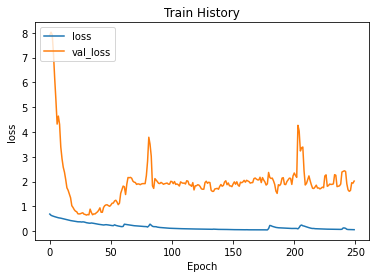

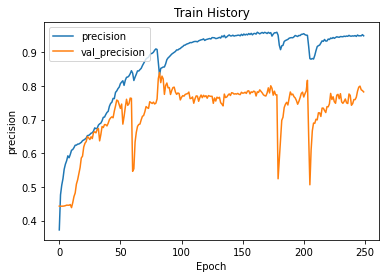

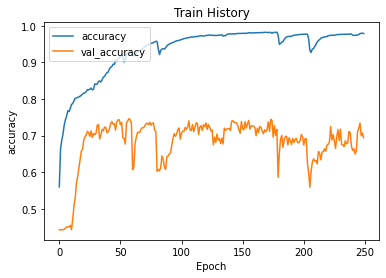

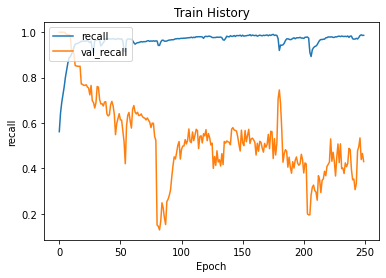

S08.001: 2972 cases

S08.004: 32692 cases

S08.007: 1486 cases

S08.009: 9659 cases

S08.012: 2972 cases

S08.014: 61669 cases

S08.019: 3715 cases

S08.022: 743 cases

S08.024: 14117 cases

S08.027: 34921 cases

S08.029: 12631 cases

S08.031: 2972 cases

S08.034: 8916 cases

S08.037: 3715 cases

S08.040: 743 cases

S08.043: 2972 cases

S08.047: 8173 cases

S08.049: 8916 cases

S08.051: 88417 cases

S08.053: 8173 cases

S08.056: 28234 cases

S08.059: 2229 cases

S08.061: 24519 cases

S08.065: 1486 cases

S08.070: 75786 cases

S08.072: 98819 cases

S08.074: 48295 cases

S08.076: 57954 cases

S08.079: 2229 cases

S08.086: 9659 cases

S08.090: 34921 cases

S08.092: 95104 cases

S08.095: 2229 cases

S08.098: 1486 cases

S08.108: 16346 cases

S08.110: 52753 cases

S08.114: 29720 cases

S08.120: 42351 cases

S08.123: 8916 cases

S08.125: 28234 cases

S08.129: 8916 cases

S08.135: 8916 cases

S08.142: 33435 cases

S08.146: 3715 cases

S08.149: 39379 cases

S08.151: 19318 cases

S08.154: 6687 

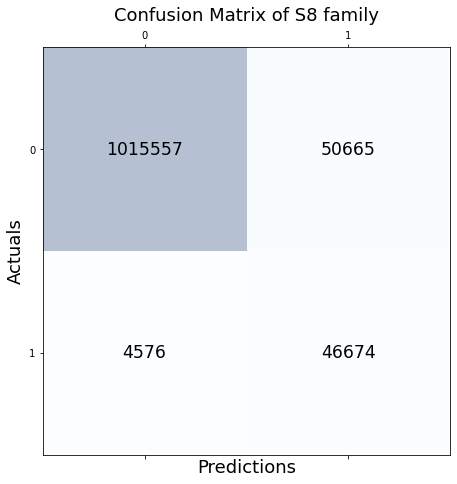

Precision: 0.479, Recall: 0.911, Accuracy: 0.951


In [ ]:

epochs = 250
rounds = 1
results = []
avg_precision = []
avg_recall = []
avg_acc = []

def experiment_NN() :
    for i in range(rounds) :
        model, history = go_nn(epochs)
        tmp_result = test_model(model)
        total_conf = [[0, 0], [0, 0]]
        for i in range(len(tmp_result)) :
            for j in range(2) :
                for k in range(2) :
                    total_conf[j][k] += tmp_result[i][j][k]
        tmp_pre = total_conf[1][1] / (total_conf[1][1] + total_conf[0][1])
        tmp_recall = total_conf[1][1] / (total_conf[1][1] + total_conf[1][0])
        tmp_acc = (total_conf[0][0] + total_conf[1][1]) / (total_conf[0][0] + total_conf[1][1] + total_conf[0][1] + total_conf[1][0])

        results.append(tmp_result)
        
        avg_acc.append(tmp_acc)
        avg_precision.append(tmp_pre)
        avg_recall.append(tmp_recall)
        show_result(tmp_result)
        model.save('model_' + str(i) + '.h5')
        # save_shits(result, 'CMs_' + str(i))
        # save_shits([history.history['loss'], history.history['val_loss']], 'LR_' + str(i))

experiment_NN()
